In [8]:
%%capture
!pip install path
!pip install torchsummaryX
!pip install fastcore
!pip install fastscript

# Utils

In [ ]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 7.2 GB  | Proc size: 8.1 GB
GPU RAM Free: 1932MB | Used: 13147MB | Util  87% | Total 15079MB


In [ ]:
torch.cuda.empty_cache()

In [ ]:
printm()

Gen RAM Free: 7.2 GB  | Proc size: 8.1 GB
GPU RAM Free: 132MB | Used: 14947MB | Util  99% | Total 15079MB


In [ ]:
import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [ ]:
getsize(t_choices)/1024/1024

1.121612548828125

In [ ]:
# from text import *

In [ ]:
# from fastai import *
# from fastai.text import *
# from fastai.callbacks import *
# import pandas as pd

# Download Dataset

In [ ]:
!wget http://www.statmt.org/europarl/v7/europarl.tgz

--2020-10-28 22:12:36--  http://www.statmt.org/europarl/v7/europarl.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1570461714 (1.5G) [application/x-gzip]
Saving to: ‘europarl.tgz’

europarl.tgz        100%[===================>]   1.46G   214KB/s    in 41m 48s 

2020-10-28 22:54:25 (611 KB/s) - ‘europarl.tgz’ saved [1570461714/1570461714]



In [ ]:
%%capture
!tar -xvf  '/content/europarl.tgz' -C '/content/tmp'

# Create and Process Text Data

In [54]:
from text import *

In [55]:
max_words = 2000000
max_lenght = 3 # between 2 and 20
name = "data"
n_jobs = 3
p = 0.7

# answer = input("do you need to create new dataset files (y/n)?: ")
# answer = answer.lower()
cfiles = False

In [ ]:
%%time
# df = main(labels, max_words, max_lenght, name, n_jobs, cfiles)
df = create_dataframe(labels, create_files=cfiles, max_words=max_words, n_jobs=n_jobs)
l = len(df)
idxs = np.random.permutation(l)
train_ds = df.loc[idxs[:int(p*l)]]
valid_ds = df.loc[idxs[int(p*l)+1:]]
train_ds.reset_index(drop=True, inplace=True)
valid_ds.reset_index(drop=True, inplace=True)
save_dataframe("train_ds", train_ds)
save_dataframe("valid_ds", valid_ds)

In [47]:
# dataframe = create_dataframe(labels, create_files=cfiles, max_words=max_words, n_jobs=n_jobs)

In [56]:
# dataframe.to_pickle("/content/{}0.pkl".format(name))

In [57]:
# def assemble(x, y):
#     ys = set(y)
#     texts = {k:"" for k in ys}
#     for x0, y0 in zip(x, y):
#         x0 = " " + x0
#         texts[y0] += x0
#     xs = texts.values()
#     return pd.DataFrame(xs), pd.Series(list(ys))

In [59]:
# valid_df = pd.read_pickle("/content/drive/My Drive/europarl/valid_ds.pkl")

In [60]:
# valid_df.columns

Index(['text', 'label'], dtype='object')

In [ ]:
# d = assemble(valid_df["text"].values, valid_df["label"].values)

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp -R "/content/europarl" "/content/drive/My Drive/"

# Clone Repository

In [14]:
!git clone https://github.com/rashidhaffadi/Language-Identification.git

fatal: destination path 'Language-Identification' already exists and is not an empty directory.


In [16]:
cp -r /content/Language-Identification/* /content/

In [12]:
rm -R /content/*

# Train AWD_LSTM Model Using Custom Tokenization

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
! cp "/content/drive/My Drive/europarl/tokenizer.pkl" /content/tokenizer.pkl
! cp  "/content/drive/My Drive/europarl/text.py" /content/text.py
! cp  "/content/drive/My Drive/europarl/tokenizer.py" /content/tokenizer.py
! cp  "/content/drive/My Drive/europarl/vocab.py" /content/vocab.py

In [1]:
from tokenizer import SpecialTokenizer, _default_tokenizer
from fastai.text.models.transformer import init_transformer
from fastai import *
from fastai.text import *
from fastai.callbacks import *
import pandas as pd
import numpy as np
import gc

In [2]:
labels=['bg','cs','da','de','el','en','es','et','fi','fr',
        'hu','it','lt','lv','nl','pl','pt','ro','sk','sl','sv']

In [3]:
train_df = pd.read_pickle("/content/drive/My Drive/europarl/train_ds.pkl")
valid_df = pd.read_pickle("/content/drive/My Drive/europarl/valid_ds.pkl")
train_df.shape, valid_df.shape

((2718013, 2), (1164863, 2))

In [4]:
# np.random.seed(1)
t_choices = np.random.choice(len(train_df), int(210000*0.7))
v_choices = np.random.choice(len(valid_df), int(210000*0.3))

In [5]:
def sup_two(row):
    if len(row['text'].split()) <= 2 : return 0
    else: return row['text']

In [6]:
# taking sample
train_df = train_df.loc[t_choices]
valid_df = valid_df.loc[v_choices]

train_df['text'] = train_df.apply(sup_two, axis=1)
valid_df['text'] = valid_df.apply(sup_two, axis=1)

train_df = train_df[train_df.text != False]
valid_df = valid_df[valid_df.text != False]

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

train_df.shape, valid_df.shape

((132361, 2), (56621, 2))

In [7]:
max_len = max([len(x.split()) for x in train_df.text])
min_len = min([len(x.split()) for x in train_df.text])
max_len, min_len

(21, 3)

In [8]:
t = SpecialTokenizer.from_pickle("/content/tokenizer.pkl")

In [9]:
def get_tokens(t):
    return list(t.vocab.get_vocab().keys())
v = Vocab(get_tokens(t))

In [10]:
def flatten(rank_2):
    return list(itertools.chain.from_iterable(rank_2))

In [11]:
trn_tok = [flatten(t.tokenize_single(x)) for x in train_df['text']]
val_tok = [flatten(t.tokenize_single(x)) for x in valid_df['text']]
len(trn_tok), len(val_tok)

(132361, 56621)

In [12]:
# print("size: {}".format(getsize(trn_tok)/1024/1024))

In [13]:
trn_lbls = train_df.label
val_lbls = valid_df.label
lbs = list(range(len(labels)))

In [14]:
del train_df, valid_df
gc.collect()

0

In [15]:
bs = 64

In [16]:
tdb = TextClasDataBunch.from_tokens('.', trn_tok, trn_lbls, val_tok, val_lbls, vocab=v, max_vocab=200000, bs=bs)

In [17]:
del trn_tok, val_tok
gc.collect()

0

In [23]:
metrics = [accuracy, FBeta(beta=1)]

In [27]:
config = dict(emb_sz=64*4, n_hid=32, n_layers=4, pad_token=0, qrnn=False, bidir=False, output_p=0.4,
                hidden_p=0.3, input_p=0.4, embed_p=0.05, weight_p=0.5)

In [28]:
clf = text_classifier_learner(tdb, AWD_LSTM, drop_mult=0.1, metrics=metrics, 
                                pretrained=False, config=config)
clf.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [25, 256]            0          False     
______________________________________________________________________
RNNDropout           [25, 32]             0          False     
______________________________________________________________________
RNNDropout           [25, 32]             0          False     
______________________________________________________________________
RNNDropout           [25, 32]             0          False     
______________________________________________________________________
BatchNorm1d          [768]                1,536      True      
______________________________________________________________________
Dropout              [768]                0          False     
______________________________________________________________________
Linear               [50]                 38,450     True      
________________________________________________

In [ ]:
# learn.freeze()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


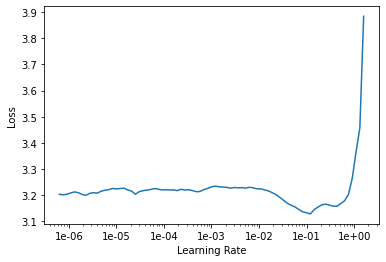

In [22]:
clf.lr_find()
clf.recorder.plot()

In [21]:
cbs = [SaveModelCallback(clf, every='epoch', monitor='accuracy', name='awd_model')]

In [29]:
clf.fit_one_cycle(5, 1e-03, callbacks=cbs)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.078121,0.093946,0.971530,0.971721,05:09
1,0.079514,0.058298,0.982904,0.983037,04:33
2,0.037626,0.039631,0.989103,0.989131,04:32
3,0.019760,0.029084,0.992211,0.992217,04:39
4,0.004781,0.024959,0.993748,0.993738,05:04


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was s

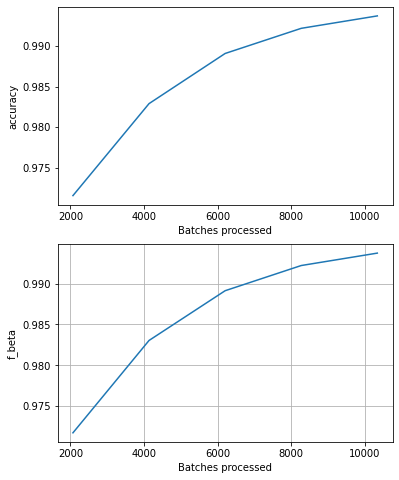

In [31]:
clf.recorder.plot_metrics(show_grid=True)

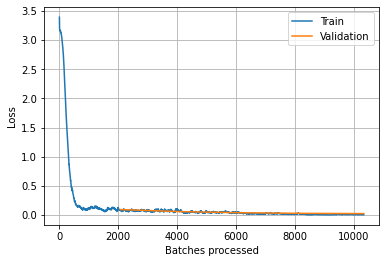

In [30]:
clf.recorder.plot_losses(show_grid=True)

# AWD_LSTM2

In [37]:
from awd_lstm import *

In [35]:
! cp "/content/drive/My Drive/europarl/tokenizer.pkl" /content/tokenizer.pkl
! cp "/content/drive/My Drive/europarl/train_ds.pkl" /content/train_ds.pkl
! cp "/content/drive/My Drive/europarl/valid_ds.pkl" /content/valid_ds.pkl

In [30]:
trn, val, tst = read_ds("/content/drive/My Drive/europarl/train_ds.pkl", "/content/drive/My Drive/europarl/valid_ds.pkl")
t = SpecialTokenizer.from_pickle("/content/tokenizer.pkl")

In [31]:
trn, val = sample(200000, trn, val, p=0.7)

In [ ]:
v = Vocab(get_tokens(t))
trn_tok = tokenize(t, trn_df["text"])
val_tok = tokenize(t, val_df["text"])
trn_lbls = trn_df.label
val_lbls = val_df.label
print(len(trn_tok))
# tdb = TextClasDataBunch.from_tokens(path, trn_tok, trn_lbls, val_tok, val_lbls, vocab=v, max_vocab=max_vocab, bs=bs)

In [ ]:
model = main(5)

--KeyboardInterrupt--


# Sequence Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp "/content/drive/My Drive/europarl/tokenizer.pkl" /content/tokenizer.pkl 
! cp  "/content/drive/My Drive/europarl/text.py" /content/text.py
! cp  "/content/drive/My Drive/europarl/tokenizer.py" /content/tokenizer.py
! cp  "/content/drive/My Drive/europarl/vocab.py" /content/vocab.py

In [4]:
from tokenizer import SpecialTokenizer, _default_tokenizer
from fastai import *
from fastai.text import *
from fastai.callbacks import *
import pandas as pd
import numpy as np
import gc
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchsummaryX import summary

In [5]:
labels=['bg','cs','da','de','el','en','es','et','fi','fr',
        'hu','it','lt','lv','nl','pl','pt','ro','sk','sl','sv']

In [6]:
train_df = pd.read_pickle("/content/drive/My Drive/europarl/train_ds.pkl")
valid_df = pd.read_pickle("/content/drive/My Drive/europarl/valid_ds.pkl")
train_df.shape, valid_df.shape

((2718013, 2), (1164863, 2))

In [7]:
np.random.seed(1)
t_choices = np.random.choice(len(train_df), int(105000*4*0.7))
v_choices = np.random.choice(len(valid_df), int(105000*4*0.3))

In [8]:
def sup_two(row):
    if len(row['text'].split()) <= 1: return 0
    else: return row['text']

In [9]:
# taking sample
train_df = train_df.loc[t_choices]
valid_df = valid_df.loc[v_choices]

train_df['text'] = train_df.apply(sup_two, axis=1)
valid_df['text'] = valid_df.apply(sup_two, axis=1)

train_df = train_df[train_df.text != False]
valid_df = valid_df[valid_df.text != False]

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

train_df.shape, valid_df.shape

((279444, 2), (119541, 2))

In [ ]:
# train_df.groupby('label').size(), valid_df.groupby('label').size()

In [10]:
max_len = max([len(x.split()) for x in train_df.text])
min_len = min([len(x.split()) for x in train_df.text])
max_len, min_len

(23, 2)

In [11]:
t = SpecialTokenizer.from_pickle("/content/tokenizer.pkl")

In [ ]:
# class SpecialVocab(Vocab):
#     def numericalize(self, t,):
#         return self.pad([[self.stoi[sw] for sw in w] for w in t])

#     def pad(self, seq, pad_idx=0):
#         lens = []
#         for row in seq:
#             lens.append(len(row))
#         max_len = max(lens)
#         for row in seq:
#             while len(row) < max_len:
#                 row.append(pad_idx)

#         return seq  

#     def textify(self, nums, sep=' '):
#         return sep.join(flatten([[self.itos[i] for i in j] for j in nums])) if sep is not None else flatten([[self.itos[i] for i in j] for j in nums])

# def get_tokens(t):
#     return list(t.vocab.get_vocab().keys())
# v = SpecialVocab(get_tokens(t))

In [12]:
def get_tokens(t):
    return list(t.vocab.get_vocab().keys())
v = Vocab(get_tokens(t))

In [13]:
def flatten(rank_2):
    return list(itertools.chain.from_iterable(rank_2))

In [ ]:
# def special_tokenize(x, i):
#     return flatten(t.tokenize_single(x))

# trn_tok = parallel_function(special_tokenize, train_df['text'].tolist(), 1)
# val_tok = parallel_function(special_tokenize, valid_df['text'].tolist(), 1)

In [14]:
# with flatten
%%time

trn_tok = [flatten(t.tokenize_single(x)) for x in train_df['text']]
val_tok = [flatten(t.tokenize_single(x)) for x in valid_df['text']]
len(trn_tok), len(val_tok)

CPU times: user 1min 3s, sys: 2.55 s, total: 1min 5s
Wall time: 1min 5s


In [15]:
val_lbls = valid_df.label.to_list()
trn_lbls = train_df.label.to_list()


In [16]:
del train_df, valid_df
gc.collect()

0

In [17]:
bs = 64

In [18]:
tdb = TextClasDataBunch.from_tokens('.', trn_tok, trn_lbls, val_tok, val_lbls, vocab=v, max_vocab=200000, bs=bs)

In [ ]:
# tdb.loss_func

FlattenedLoss of CrossEntropyLoss()

In [19]:
del trn_tok, val_tok
gc.collect()

0

In [28]:
class SequenceModel(nn.Module):
    def __init__(self, num_of_ngrams=159694, output_size=21, hidden_size=64, embedding_dim=64, drp=0.1):
        super().__init__()

        self.chars_embedding = nn.Embedding(num_embeddings=num_of_ngrams, padding_idx=0, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(num_layers=2, input_size=embedding_dim, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        self.linear1 = nn.Linear(hidden_size*2, output_size*4)
        self.bn1 = nn.BatchNorm1d(output_size*4)
        self.dropout1 = nn.Dropout(drp)
        self.linear2 = nn.Linear(output_size*4, output_size*2)
        self.bn2 = nn.BatchNorm1d(output_size*2)
        self.dropout2 = nn.Dropout(drp)
        self.linear3 = nn.Linear(output_size*2, output_size)
        self.with_gpu()

    def with_gpu(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def reset(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def smouthing(self, o):
        a = o.argmax(1)
        a = F.one_hot(a, num_classes=o.shape[1]).float()
        return a.clone().detach().requires_grad_(True)

    def forward(self, x): #x: tokenized_texts

        out = self.chars_embedding(x)

        # print("" + str(out.shape))
        out, hidden = self.lstm(out)
        out = out.sum(1)/x.shape[1]

        out = self.linear1(out)
        out = self.bn1(out)
        out = self.dropout1(out)
        out = F.relu(out)

        out = self.linear2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        our = F.relu(out)

        out = self.linear3(out)
        out = F.softmax(out, dim=1)
        return out

In [29]:
model = SequenceModel()
model

SequenceModel(
  (chars_embedding): Embedding(159694, 64, padding_idx=0)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=128, out_features=84, bias=True)
  (bn1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=84, out_features=42, bias=True)
  (bn2): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (linear3): Linear(in_features=42, out_features=21, bias=True)
)

In [30]:
f1 = FBeta(beta=1, average="micro")
metrics = [accuracy, f1]

In [31]:
clf = Learner(tdb, model, metrics=metrics)
summary(model, torch.zeros((bs, 720), dtype=torch.long).cuda())

                   Kernel Shape    Output Shape      Params   Mult-Adds
Layer                                                                  
0_chars_embedding  [64, 159694]   [64, 720, 64]  10.220416M  10.220416M
1_lstm                        -  [64, 720, 128]    165.888k     163.84k
2_linear1             [128, 84]        [64, 84]     10.836k     10.752k
3_bn1                      [84]        [64, 84]       168.0        84.0
4_dropout1                    -        [64, 84]           -           -
5_linear2              [84, 42]        [64, 42]       3.57k      3.528k
6_bn2                      [42]        [64, 42]        84.0        42.0
7_dropout2                    -        [64, 42]           -           -
8_linear3              [42, 21]        [64, 21]       903.0       882.0
-----------------------------------------------------------------------
                          Totals
Total params          10.401865M
Trainable params      10.401865M
Non-trainable params         0.0
Mult

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_chars_embedding,"[64, 159694]","[64, 720, 64]",10220416.0,10220416.0
1_lstm,-,"[64, 720, 128]",165888.0,163840.0
2_linear1,"[128, 84]","[64, 84]",10836.0,10752.0
3_bn1,[84],"[64, 84]",168.0,84.0
4_dropout1,-,"[64, 84]",NaN,NaN
5_linear2,"[84, 42]","[64, 42]",3570.0,3528.0
6_bn2,[42],"[64, 42]",84.0,42.0
7_dropout2,-,"[64, 42]",NaN,NaN
8_linear3,"[42, 21]","[64, 21]",903.0,882.0


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


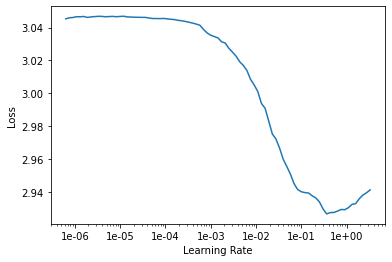

In [24]:
# %%debug
clf.lr_find()
clf.recorder.plot()

In [43]:
clf.fit_one_cycle(2, 1e-02)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.160538,2.156289,0.967041,0.967041,05:16
1,2.147256,2.138657,0.984482,0.984482,05:26


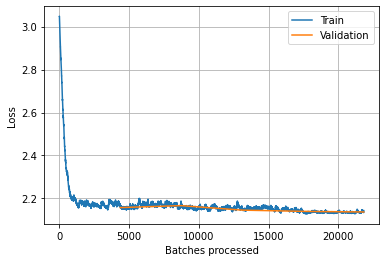

In [35]:
clf.recorder.plot_losses(show_grid=True)

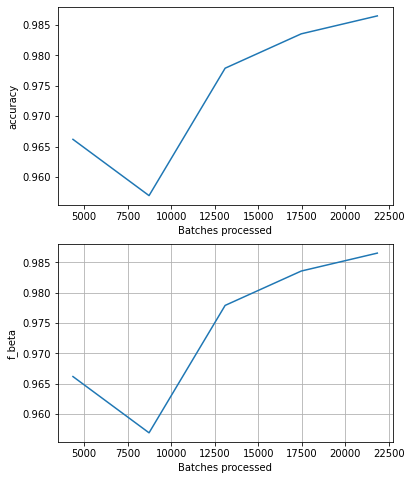

In [40]:
clf.recorder.plot_metrics(show_grid=True)

# Transformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! cp "/content/drive/My Drive/europarl/tokenizer.pkl" /content/tokenizer.pkl 
# ! cp  "/content/drive/My Drive/europarl/text.py" /content/text.py
# ! cp  "/content/drive/My Drive/europarl/tokenizer.py" /content/tokenizer.py
# ! cp  "/content/drive/My Drive/europarl/vocab.py" /content/vocab.py

In [1]:
from tokenizer import SpecialTokenizer, _default_tokenizer
from fastai.text.models.transformer import init_transformer
from fastai import *
from fastai.text import *
from fastai.callbacks import *
import pandas as pd
import numpy as np
import gc

In [2]:
labels=['bg','cs','da','de','el','en','es','et','fi','fr',
        'hu','it','lt','lv','nl','pl','pt','ro','sk','sl','sv']

In [3]:
train_df = pd.read_pickle("/content/drive/My Drive/europarl/train_ds.pkl")
valid_df = pd.read_pickle("/content/drive/My Drive/europarl/valid_ds.pkl")
train_df.shape, valid_df.shape

((2718013, 2), (1164863, 2))

In [4]:
np.random.seed(1)
t_choices = np.random.choice(len(train_df), int(210000*0.7))
v_choices = np.random.choice(len(valid_df), int(210000*0.3))

In [5]:
def sup_two(row):
    if len(row['text'].split()) <= 1: return 0
    else: return row['text']

In [6]:
# taking sample
train_df = train_df.loc[t_choices]
valid_df = valid_df.loc[v_choices]

train_df['text'] = train_df.apply(sup_two, axis=1)
valid_df['text'] = valid_df.apply(sup_two, axis=1)

train_df = train_df[train_df.text != False]
valid_df = valid_df[valid_df.text != False]

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

train_df.shape, valid_df.shape

((139773, 2), (59909, 2))

In [7]:
max_len = max([len(x.split()) for x in train_df.text])
min_len = min([len(x.split()) for x in train_df.text])
max_len, min_len

(23, 2)

In [8]:
t = SpecialTokenizer.from_pickle("/content/tokenizer.pkl")

In [9]:
def get_tokens(t):
    return list(t.vocab.get_vocab().keys())
v = Vocab(get_tokens(t))

In [10]:
def flatten(rank_2):
    return list(itertools.chain.from_iterable(rank_2))

In [11]:
trn_tok = [flatten(t.tokenize_single(x)) for x in train_df['text']]
val_tok = [flatten(t.tokenize_single(x)) for x in valid_df['text']]
len(trn_tok), len(val_tok)

(139773, 59909)

In [12]:
# print("size: {}".format(getsize(trn_tok)/1024/1024))

In [13]:
trn_lbls = train_df.label
val_lbls = valid_df.label
lbs = list(range(len(labels)))

In [14]:
del train_df, valid_df
gc.collect()

0

In [15]:
bs = 64

In [16]:
tdb = TextClasDataBunch.from_tokens('.', trn_tok, trn_lbls, val_tok, val_lbls, vocab=v, max_vocab=200000, bs=bs)

In [17]:
del trn_tok, val_tok
gc.collect()

0

In [18]:
f1 = FBeta(average="micro", beta=1)
metrics = [accuracy, f1]

In [19]:
config = dict(ctx_len=512, n_layers=2, n_heads=16, d_model=32, d_head=2, d_inner=64, resid_p=0.2, attn_p=0.2,
                         ff_p=0.2, embed_p=0.2, output_p=0., bias=True, scale=True, act=Activation.GeLU, double_drop=False,
                         init=init_transformer, mask=False)

In [20]:
clf = text_classifier_learner(tdb, Transformer, drop_mult=0.5, metrics=metrics, 
                                pretrained=False, config=config)
clf.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [67, 32]             4,373,760  True      
______________________________________________________________________
Embedding            [32]                 16,384     True      
______________________________________________________________________
Dropout              [67, 32]             0          False     
______________________________________________________________________
Linear               [67, 96]             3,168      True      
______________________________________________________________________
Linear               [67, 32]             1,056      True      
______________________________________________________________________
Dropout              [16, 67, 67]         0          False     
______________________________________________________________________
Dropout              [67, 32]             0          False     
________________________________________________

In [21]:
# learn.freeze()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


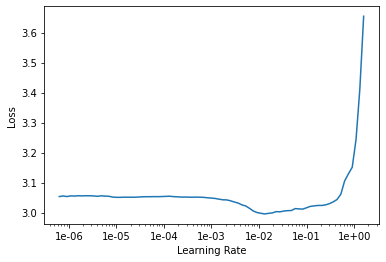

In [22]:
clf.lr_find()
clf.recorder.plot()

In [24]:
cbs = [SaveModelCallback(clf, every='epoch', monitor='accuracy', name='transformer_model')]

In [25]:
clf.fit_one_cycle(5, 1e-02, callbacks=cbs)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.174600,0.630514,0.819760,0.819760,02:26
1,0.075685,0.099488,0.972792,0.972792,02:48
2,0.046049,0.053655,0.985929,0.985929,02:48
3,0.027817,0.042962,0.989334,0.989334,02:50
4,0.024665,0.038952,0.990302,0.990302,02:39


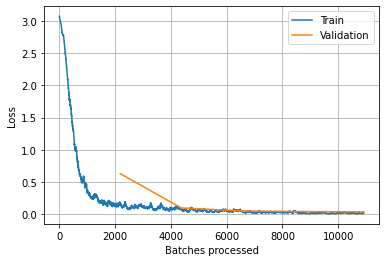

In [26]:
clf.recorder.plot_losses(show_grid=True)

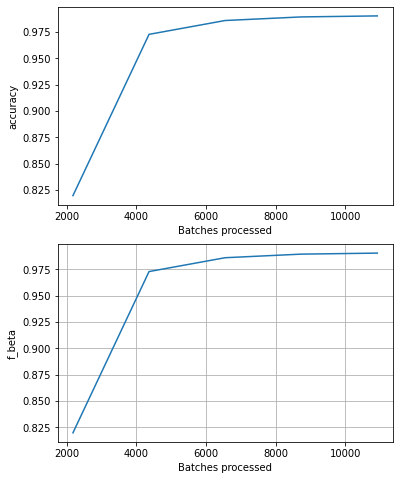

In [27]:
clf.recorder.plot_metrics(show_grid=True)